In [1]:
import foolbox as fb
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

# from fw_attacks_implementation import *
from utils import *

### Setup

In [2]:
# SETTINGS

SEED = 0
torch.manual_seed(SEED)  # doesn't seem to work on mac
USE_MANUAL_INDICES_PERMUTATION = True

DATASET_SIZE = 5  # 20 or full

# EPSILONS = [0.0, 0.0001, 0.0003, 0.0005, 0.0008, 0.001, 0.003, 0.005, 0.008, 0.01, 0.03, 0.05, 0.08, 0.1, 0.3, 0.5, 0.8, 1.0]
EPSILONS = [0.0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]

In [3]:
# Load pre-trained model for CIFAR10 dataset from: https://github.com/chenyaofo/pytorch-cifar-models 
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True, verbose=False)
model.eval()

# Load CIFAR10 test dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

full_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
classes = full_test_dataset.classes
print("Classes:", classes)

# Get subset of test dataset
if USE_MANUAL_INDICES_PERMUTATION:
    indices = [6635, 4167, 1253, 7888, 636]  # 5 randomly preselected images
else:
    indices = torch.randperm(len(full_test_dataset)).tolist()[:DATASET_SIZE]
    
test_dataset = torch.utils.data.Subset(full_test_dataset, indices)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
print("Subset indices:", indices)

Files already downloaded and verified
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Subset indices: [6635, 4167, 1253, 7888, 636]


### PGD & FGSM attacks with `foolbox`

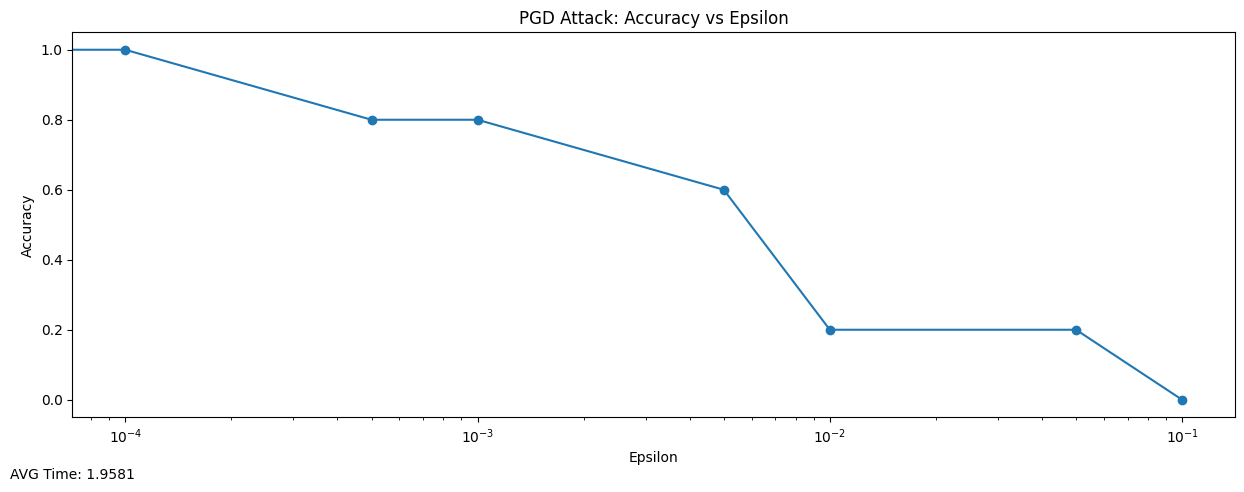

In [4]:
fb_model = fb.PyTorchModel(model, bounds=(0, 1))

# Projected Gradient Descent attack
pgd_attack = fb.attacks.LinfPGD()
pgd_accuracies, pgd_time = attack_and_collect_stats(EPSILONS, fb_model, pgd_attack, test_loader, "PGD")

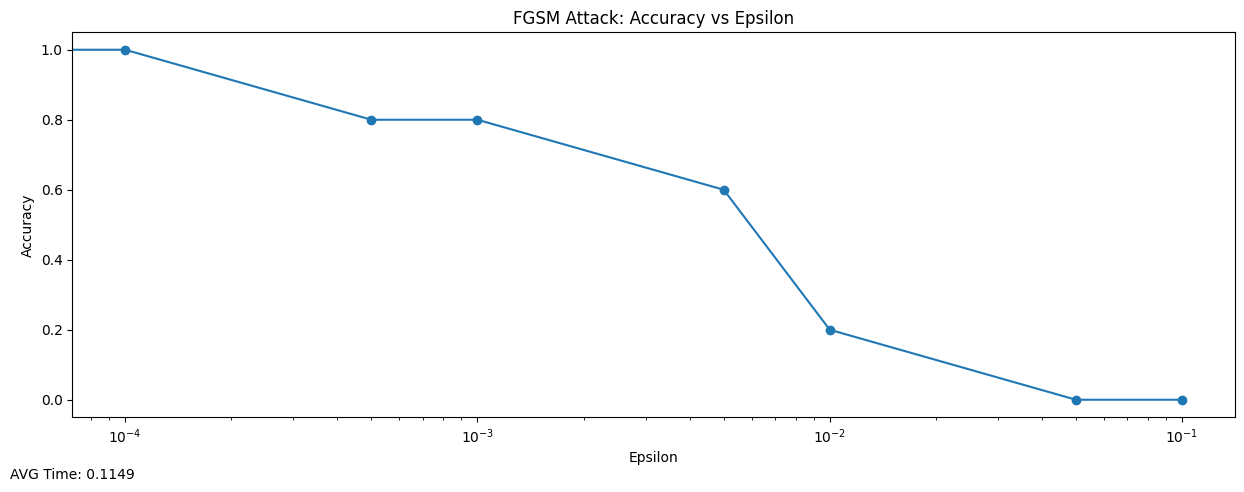

In [5]:
# Fast Gradient Sign Method attack
fgsm_attack = fb.attacks.LinfFastGradientAttack()
fgsm_accuracies, fgsm_time = attack_and_collect_stats(EPSILONS, fb_model, fgsm_attack, test_loader, "FGSM")

### Frank-Wolfe attacks

In [26]:
def frank_wolfe_attack_local(model, images, labels, epsilon, params):
    num_steps = params['num_steps']
    p_norm = params['p_norm']

    delta = torch.zeros_like(images, requires_grad=True)
    
    for k in range(num_steps):
        outputs = model(images + delta)
        loss = -F.nll_loss(outputs, labels)
        loss.backward()
        
        # LMO
        if p_norm == -1:  # p_norm - норма для ограничения возмущения
            grad_sign = delta.grad.data.sign()
            s_k = -epsilon * grad_sign + images
        else:
            grad_norm = torch.norm(delta.grad.data, p=float(p_norm), dim=(1, 2, 3), keepdim=True)
            s_k = epsilon * delta.grad.data / grad_norm
        
        gamma_k = 2 / (k + 2)
        
        delta.data = (1 - gamma_k) * delta.data + gamma_k * s_k
        
        delta.grad.data.zero_()
    
    with torch.no_grad():
        perturbed_images = images + delta
        perturbed_images = torch.clamp(perturbed_images, 0, 1)
    
    return images, perturbed_images, delta

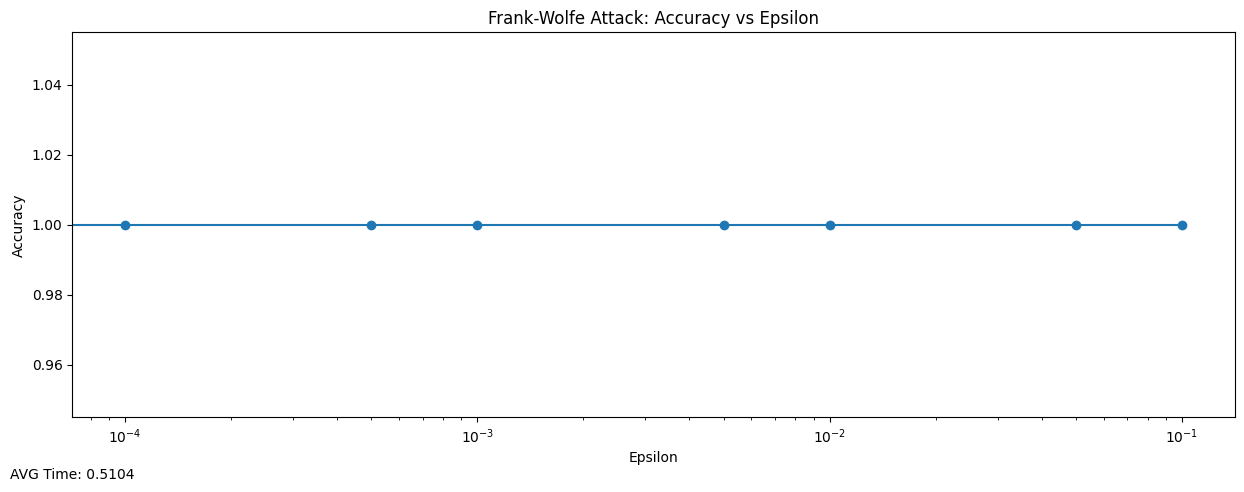

In [28]:
# Basic Frank-Wolfe attack
bfw_params = {"num_steps": 10, "p_norm": 2}
bfw_accuracies, bfw_time = attack_and_collect_stats(EPSILONS, model, frank_wolfe_attack_local, test_loader, "Frank-Wolfe", bfw_params)